<a href="https://colab.research.google.com/github/VegiMohan/RGB-Based-Face-Anti-Spoofing-with-Edge-Augmented-Deep-Learning/blob/main/RGB_Based_Face_Anti_Spoofing_with_Edge_Augmented_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import roc_curve


1. RGB Dataset with edge detection

In [ ]:
class FaceAntiSpoofDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Cannot read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200) / 255.0

        image = cv2.resize(image, (224, 224))
        edges = cv2.resize(edges, (224, 224))

        if self.transform:
            image = self.transform(image)

        edge_tensor = torch.tensor(edges, dtype=torch.float32).unsqueeze(0)
        combined = torch.cat([image, edge_tensor], dim=0)

        return combined, torch.tensor(label, dtype=torch.float32)

2.  ResNet-18 Model

In [ ]:

class AntiSpoofModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1)

    def forward(self, x):
        x = self.backbone(x)
        return torch.sigmoid(x).squeeze(1)


3. Metrics

APCER: Attack Presentation Classification Error Rate

BPCER: Bona Fide Presentation Classification Error Rate

ACER: Average Classification Error Rate

EER: Equal Error Rate

EER Threshold: Equal Error Rate Threshold



In [ ]:
def calculate_metrics(y_true, y_pred_scores, threshold=0.5):
    y_pred = (y_pred_scores >= threshold).astype(int)
    apcer = np.sum((y_true == 1) & (y_pred == 0)) / np.sum(y_true == 1)
    bpcer = np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_true == 0)
    acer = (apcer + bpcer) / 2
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return {'APCER': apcer, 'BPCER': bpcer, 'ACER': acer, 'EER': eer, 'EER_threshold': eer_threshold}


4. Evaluation

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    metrics = calculate_metrics(all_labels, all_scores)
    return metrics

5. Training

In [ ]:

def train(model, train_loader, val_loader, device, epochs=5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1} Batch {batch_idx+1}/{len(train_loader)} Loss: {running_loss / 10:.4f}")
                running_loss = 0.0
        metrics = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1} validation -> ACER: {metrics['ACER']:.4f}, APCER: {metrics['APCER']:.4f}, BPCER: {metrics['BPCER']:.4f}, EER: {metrics['EER']:.4f}")

6. Mock data generator-CREATES RANDOM RGB IMAGES

In [ ]:

def create_mock_images_and_labels(num_samples=20, img_size=(224, 224)):
    base_dir = "mock_data"
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    train_image_paths = []
    train_labels = []
    val_image_paths = []
    val_labels = []

    for split_dir, image_paths, labels in [(train_dir, train_image_paths, train_labels),
                                           (val_dir, val_image_paths, val_labels)]:
        for i in range(num_samples):
            img_array = np.random.randint(0, 256, size=(*img_size, 3), dtype=np.uint8)
            img = Image.fromarray(img_array)
            label = random.choice([0, 1])
            filename = f"{'live' if label == 0 else 'spoof'}_{i}.jpg"
            filepath = os.path.join(split_dir, filename)
            img.save(filepath)
            image_paths.append(filepath)
            labels.append(label)
    return train_image_paths, train_labels, val_image_paths, val_labels

7.MODEL TRAINING

In [ ]:
if __name__ == "__main__":
    train_image_paths, train_labels, val_image_paths, val_labels = create_mock_images_and_labels(num_samples=50)
    print(f"Created {len(train_image_paths)} training and {len(val_image_paths)} validation images.")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = FaceAntiSpoofDataset(train_image_paths, train_labels, transform=transform)
    val_dataset = FaceAntiSpoofDataset(val_image_paths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = AntiSpoofModel()

    train(model, train_loader, val_loader, device, epochs=5)


Created 50 training and 50 validation images.
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 validation -> ACER: 0.5000, APCER: 1.0000, BPCER: 0.0000, EER: 0.6000
Epoch 2 validation -> ACER: 0.5000, APCER: 1.0000, BPCER: 0.0000, EER: 0.4800
Epoch 3 validation -> ACER: 0.4800, APCER: 0.8000, BPCER: 0.1600, EER: 0.6000
Epoch 4 validation -> ACER: 0.5000, APCER: 0.2400, BPCER: 0.7600, EER: 0.6000
Epoch 5 validation -> ACER: 0.4600, APCER: 0.2000, BPCER: 0.7200, EER: 0.4400


8.HEAT MAP

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


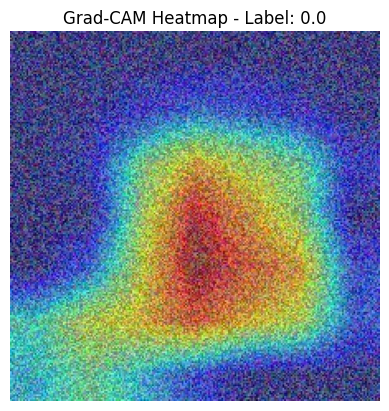

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        target = output[:, class_idx]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))
        cam -= cam.min()
        cam /= cam.max()
        return cam

# Usage example inside your main or evaluation code:

# 1. Prepare input tensor (single sample, batch size=1)
sample_input, label = val_dataset[0]
sample_input = sample_input.unsqueeze(0).to(device)

# 2. Initialize GradCAM with the last conv layer of ResNet18 (layer4)
gradcam = GradCAM(model.backbone, model.backbone.layer4[-1].conv2)

# 3. Generate heatmap
heatmap = gradcam.generate(sample_input)

# 4. Convert input tensor to numpy image for display
img = sample_input[0][:3].cpu().permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
img = np.clip(img, 0, 1)

# 5. Overlay heatmap on image
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Heatmap overlay
plt.title(f"Grad-CAM Heatmap - Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
import os

train_images = os.listdir("mock_data/train")
val_images = os.listdir("mock_data/val")

print("Train images:", train_images[:5])
print("Val images:", val_images[:5])


Train images: ['live_40.jpg', 'spoof_29.jpg', 'live_18.jpg', 'spoof_16.jpg', 'live_42.jpg']
Val images: ['spoof_29.jpg', 'live_18.jpg', 'spoof_16.jpg', 'live_42.jpg', 'spoof_37.jpg']


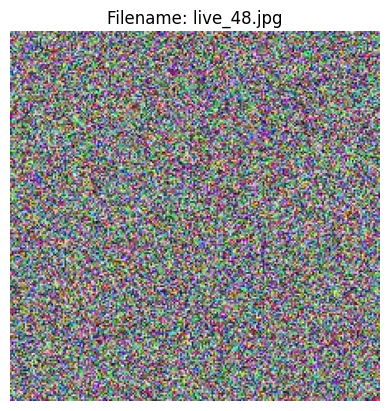

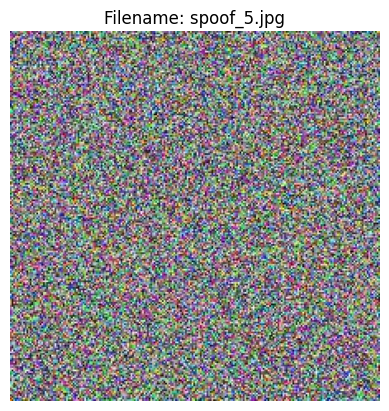

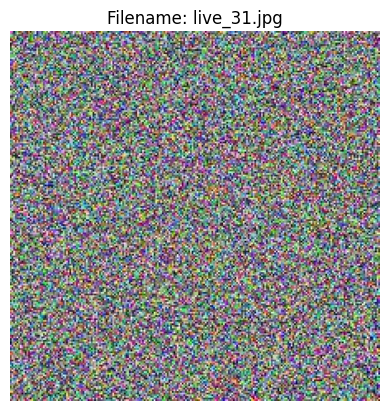

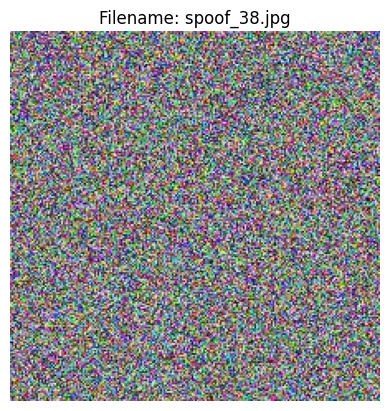

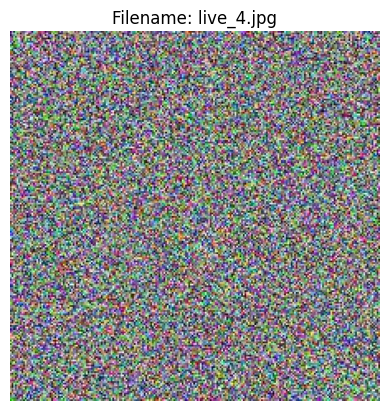

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Directory where mock images are saved
mock_dir = "mock_data/train"

# List all image files
image_files = [f for f in os.listdir(mock_dir) if f.endswith('.jpg')]

# Pick a few random ones to display
samples = random.sample(image_files, 5)

for img_name in samples:
    img_path = os.path.join(mock_dir, img_name)
    image = Image.open(img_path)

    plt.imshow(image)
    plt.title(f"Filename: {img_name}")
    plt.axis("off")
    plt.show()



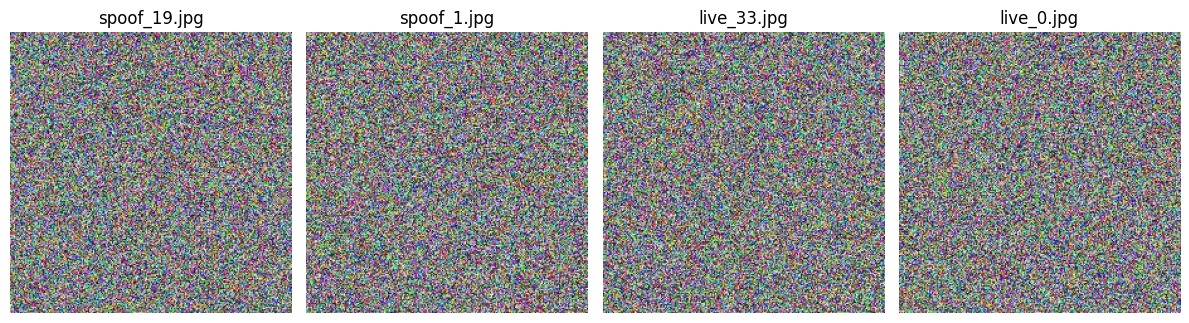

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_random_mock_images(folder="mock_data/train", count=4):
    images = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    samples = random.sample(images, min(count, len(images)))

    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, count, i + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show sample images
show_random_mock_images()
